<h1>Non-linear regression analysis for Real Estate prices</h1></br>
<p>Prepared by <b>Vytautas Bielinskas</b></p></br>
<p>Last updated: <b>2018-07-24</b></p>

<b>Plan of attack:</b>
<li>#1 <u>Import modules and packages</u></li>
<li>#2 <u>Load the dataset</u></li>
<li>--> #2.1 Get the name of the area from dataset</li>
<li>--> #2.2 Get some info on the dataset</li>
<li>--> #2.3 Parse dates</li>
<li>--> #2.4 Plot the raw dataset on a scatter plot</li>
<li>--> #2.5 ECDF function</li>
<li>--> #2.6 Input the threshold value for data cleaning</li>
<li>--> #2.7 Remove marginal data (remove data noise !!!)</li>
<li>--> #2.8 Plot dataframe on scatter plot again after data cleaning</li>
<li>--> #2.9 Calculate Simple Moving Average (SMA)</li>
<li>--> #2.10 Save the output to CSV file</li>
<li>--> #2.11 Removing first step rows for Regression Analysis</li>
<li>#3 <u>Linear regression analysis</u></li>
<li>--> #3.1 Import modules</li>
<li>--> #3.2 Set X and y varianbles</li>
<li>--> #3.3 Note the difference in argument order</li>
<li>--> #3.4 Print the model statistics</li>
<li>#4 <u>Visualize trend for Linear Regression</u></li>
<li>#5 <u>Determine additional metrics for the model</u></li>
<li>--> #5.1 Calculate Pearson correlation coefficient</li>

<h2>Data pre-processing part</h2>

<h2># 1. Import modules and packages</h2>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
from sklearn.linear_model import LinearRegression

%matplotlib inline

<h2>#2 Load the dataset</h2>

In [2]:
cwd = os.getcwd()
os.chdir(cwd)

df = pd.read_csv('Liverpool_timestamp.csv')

<h3>#2.1 Get the name of the area from dataset</h3>

In [3]:
if 'liverpool'.upper() in df.iat[0, df.columns.get_loc('TOWN')].upper():
    area = 'Liverpool'
elif 'london'.upper() in df.iat[0, df.columns.get_loc('TOWN')].upper():
    area = 'London'

print('Research area is {}.'.format(area))

Research area is Liverpool.


In [4]:
df.head()

,TOWN,ADDRESS,Times sold,Sold date,Sold price
0,Liverpool,AIRLIE GARDENS 3,2,11-10-2014,490000
1,Liverpool,AIRLIE GARDENS 3,2,2-20-2017,635000
2,Liverpool,ARGYLE ROAD 37C,2,12-23-2014,124500
3,Liverpool,ARGYLE ROAD 37C,2,2-1-2017,178000
4,Liverpool,ARGYLE ROAD 43D,2,1-7-2014,121000


<h3>#2.2 Get some info on the dataset</h3>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 5 columns):
TOWN          269 non-null object
ADDRESS       269 non-null object
Times sold    269 non-null int64
Sold date     269 non-null object
Sold price    269 non-null int64
dtypes: int64(2), object(3)
memory usage: 7.4+ KB


In [6]:
df['Sold price'].describe()

count    2.690000e+02
mean     2.829197e+05
std      1.386034e+05
min      6.400000e+04
25%      1.860000e+05
50%      2.525000e+05
75%      3.500000e+05
max      1.157500e+06
Name: Sold price, dtype: float64

<h3># 2.3 Parse dates</h3>

In [9]:
def parseDates(df):
      
    """ 
    This procedure will parse the date columns by using 
    strftime function. 
    """
    
    today = datetime.now()
    print('Today is {}, ({})'.format(today,
                              type(today)))
    
    index_of_dates = df.columns.get_loc('Sold date')
    print('The index of Sold dates is {}.\n'.format(index_of_dates))
    
    # Insert parsed date to the dataframe
    try:
        df.insert(index_of_dates, 'Date', None)
    except:
        print('Column already exist.')
        
    # Insert day_ago column to the dataframe
    try:
        df.insert(index_of_dates+1, 'Days after 1st timestamp', None)
    except:
        print('Column already exist.\n')
        
    index_of_parsed_dates = df.columns.get_loc('Date')
    index_of_delta_dates = df.columns.get_loc('Days after 1st timestamp')
    index_of_price = df.columns.get_loc('Sold price')
    
    for row in range(0, len(df), 1):
        df.iat[row, index_of_parsed_dates] = datetime.strptime(df.iat[row, index_of_dates], '%m-%d-%Y')
        df.iat[row, index_of_delta_dates] = float(str(today - df.iat[row, index_of_parsed_dates]).split(' days')[0]) + 1.0
        
        df.iat[row, index_of_price] = float(df.iat[row, index_of_price])
        
    df = df.sort_values(by='Days after 1st timestamp', ascending=True)
    
    max_day = df['Days after 1st timestamp'].max()
    print('The max. day after 1st timestamp is {}.'.format(max_day))
    
    for row in range(0, len(df), 1):
        df.iat[row, index_of_delta_dates] = float(max_day - df.iat[row, index_of_delta_dates])
        
    df['Days after 1st timestamp'] = df['Days after 1st timestamp'].astype('int64')

    return df

In [10]:
df = parseDates(df)

Today is 2018-07-24 21:19:19.538639, (<class 'datetime.datetime'>)
The index of Sold dates is 5.

Column already exist.
Column already exist.

The max. day after 1st timestamp is 3849.0.


In [11]:
df.head(10)

,TOWN,ADDRESS,Times sold,Date,Days after 1st timestamp,Sold date,Sold price
139,Liverpool,Liverpool HILL ICON BUILDING 39 FLAT 77,2,2018-04-27 00:00:00,3760,4-27-2018,365000
98,Liverpool,GREEN LANE 40,2,2018-04-26 00:00:00,3759,4-26-2018,375000
13,Liverpool,AUDREY ROAD 7,2,2018-04-20 00:00:00,3753,4-20-2018,430000
220,Liverpool,SELBORNE ROAD 11B,2,2018-04-20 00:00:00,3753,4-20-2018,300000
24,Liverpool,BENTON ROAD 18,2,2018-04-06 00:00:00,3739,4-6-2018,260000
168,Liverpool,MELBOURNE ROAD 16,2,2018-03-29 00:00:00,3731,3-29-2018,725000
226,Liverpool,SOUTH PARK CRESCENT 2,2,2018-03-26 00:00:00,3728,3-26-2018,413000
230,Liverpool,STAINES ROAD 244,2,2018-03-23 00:00:00,3725,3-23-2018,220000
155,Liverpool,KINGSTON ROAD 266,2,2018-03-23 00:00:00,3725,3-23-2018,405000
228,Liverpool,ST MARYS ROAD 32,2,2018-03-16 00:00:00,3718,3-16-2018,390000


In [12]:
df['Days after 1st timestamp'].describe()

count     269.000000
mean     2561.843866
std      1226.212889
min         0.000000
25%      1866.000000
50%      3303.000000
75%      3514.000000
max      3760.000000
Name: Days after 1st timestamp, dtype: float64

<h3># 2.4. Plot the raw dataset on scatter plot</h3>

In [13]:
def visualize_scatters(df, area):
    
    # Set the labels for plots
    title = 'Price changes in {} (© UK Land Registry API)'.format(area)
    x_label = 'Sold date'
    y_label = 'Sold price (£)'
    
    # Plot the scatter with Seaborn
    plt.figure(figsize=(8,5))
    sns.set(style="darkgrid")
    
    sns.regplot('Days after 1st timestamp', 'Sold price', df)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label) 
        
    # Plot the same scatter plot in matplotlib
    timeline = pd.Series(df['Sold price'].values, index = df['Date'])
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    timeline.plot(style = 'k.', c = '#113b6c')
    plt.show()
    return None

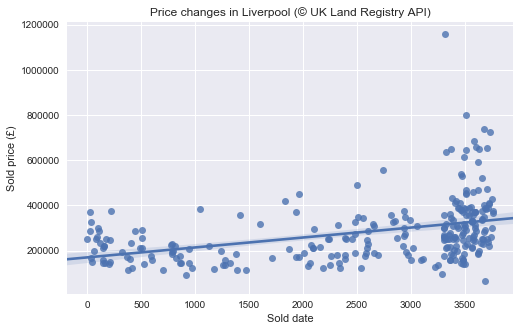

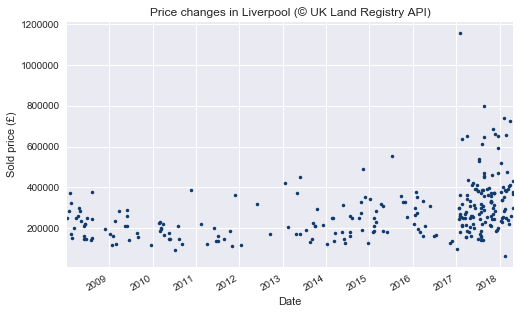

In [14]:
visualize_scatters(df, area)

<h3> # 2.5 <code>ECDF</code> function</h3>

In [15]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y

<h3> # 2.6 Input the <code>threshold<code> value for data cleaning </h3>
<p><code>threshold</code> must be less than 0.5. 
0.1 correspond to 10 %, 0.25 correspond to 25 % and so on.</p>

In [16]:
try:
    threshold = float(input('\nInput the value for threshold.\n'))
    print('You entered {} ({}) for threshold value.'.format(threshold,
                                                           type(threshold)))
except:
    print('\nFormat of value is not float or a number.')


Input the value for threshold.
0.05
You entered 0.05 (<class 'float'>) for threshold value.


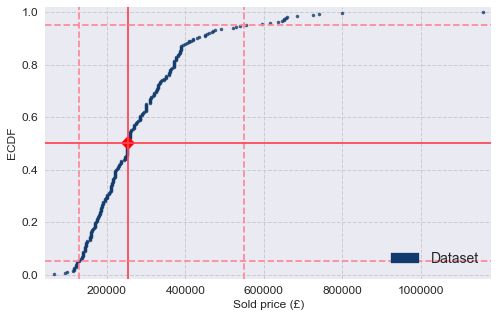

In [17]:
import matplotlib.patches as mpatches

# Set color gamma manually
primary_color = '#ff4455'
secondary_color = '#ff8899'
value_color = '#113b6c'

x, y = ecdf(df['Sold price'])

# Generate plot
sns.set_style('darkgrid')

# Set plot size
_ = plt.rcParams['figure.figsize'] = (8,5)

_ = plt.plot(x, y, marker='.', linestyle='none', color = value_color, alpha = 0.8)

# Make the margins nice
_ = plt.margins(0.02)

# Label the axes
_ = plt.xlabel('Sold price (£)', fontsize = 12, family='Arial')
_ = plt.ylabel('ECDF', fontsize = 12)

# Overlay percentiles as red diamonds.
percentiles = np.array([50])
df_perc = np.percentile(df['Sold price'], percentiles)

# Calculate quartiles of the values
quarts = df['Sold price'].quantile([threshold, 1 - threshold])
quart_1 = quarts.iloc[0]
quart_2 = quarts.iloc[1]

_ = plt.plot(df_perc, percentiles/100, marker='D', color='red', linestyle='none', markersize = 10)

# Draw vertical line on a plot
_ = plt.axvline(x = df_perc, color = primary_color)
_ = plt.axvline(x = quart_1, color = secondary_color, linestyle = '--')
_ = plt.axvline(x = quart_2, color = secondary_color, linestyle = '--')


# Draw a horizontal line on a plot
_ = plt.axhline(y = 0.5, color = primary_color)
_ = plt.axhline(y = threshold, color = secondary_color, linestyle = '--')
_ = plt.axhline(y = 1 - threshold, color = secondary_color, linestyle = '--')

plt.tick_params(labelsize=12)

# Set axis style
_ = plt.grid(b=True, which='major', color='#cccccc', linestyle='--')

# Add legend
patch = mpatches.Patch(color = value_color, label='Dataset')

_ = plt.legend(handles=[patch], loc = 'lower right', fontsize = 14)

# Display the plot
plt.show()

<h3> # 2.7 Remove marginal data (remove data noise !!!)</h3>

In [19]:
def remove_data_noise(df, quart_1, quart_2):
    print('Removing data noise\n')
    print('Quartile 1: {}.'.format(quart_1))
    print('Quartile 2: {}.'.format(quart_2))
    
    print('\nThe size of datafreme before data cleaning: {} items.'.format(len(df)))
    
    df = df[(df['Sold price'] > quart_1) & ((df['Sold price'] < quart_2))]
    
    print('The size of dataframe after data cleaning: {} items.'.format(len(df)))
    return df

In [20]:
df_cleaned = remove_data_noise(df, quart_1, quart_2)

Removing data noise

Quartile 1: 128800.0.
Quartile 2: 549299.9999999999.

The size of datafreme before data cleaning: 269 items.
The size of dataframe after data cleaning: 241 items.


In [22]:
len(df_cleaned)

241

<h3># 2.8 Plot dataframe on scatter plot again after data cleaning</h3>

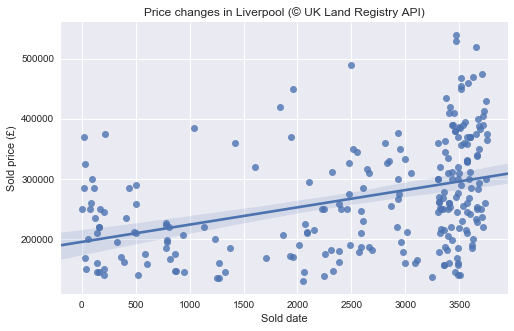

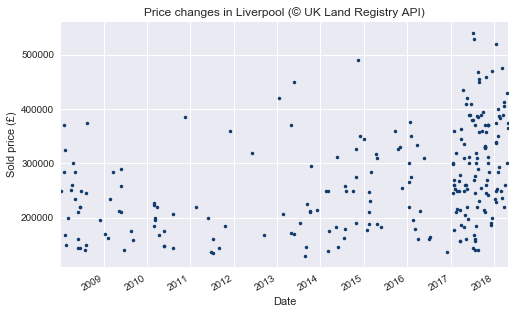

In [23]:
visualize_scatters(df_cleaned, area)

<h3>#2.9 Calculate Simple Moving Average (SMA)</h3>

In [24]:
def moving_average(values, window):
    
    """ This procedure will calculate a Numpy array
    with values of calculated SMA
    """
    
    weights = np.repeat(1.0, window) / window
    smas = np.convolve(values, weights, 'valid')
    return smas

In [25]:
def add_SMA_to_df(step, sma, df):
    
    """ This procedure add extra culumn to existing dataframe
    to put there values of SMA calculated in moving_average
    procedure.
    """
    
    try:
        df.insert(len(df.columns), 'SMA', None)
    except:
        print('\nThe columns already exists.')
    
    index_of_sma = df.columns.get_loc('SMA')
    print('\nIndex of SMA column in a dataframe is {}.\n'.format(index_of_sma))
    i = 0
    
    for row in range(0, len(df), 1):
        if row >= step:
            df.iat[row, index_of_sma] = sma[i]
            i = i + 1
            
    print('{}\n\nColumns are: {}.'.format(df.head(step+3),
                                        df.columns))
    
    return df

In [27]:
def plot_SMA(df, step, area):
    
    """ This procedure plot the SMA if it exsist on the dataframe.
    Reccomending use after moving_average and add_SMA_to_df procedures
    has being applied.
    """
    
    # Set the labels for plots
    title = 'Price changes in {} (© UK Land Registry API)\n(Moving Average, step = {} days.'.format(area,
                                                                                                    step)
    x_label = 'Sold date'
    y_label = 'Sold price (£)'
    
    timeline_1 = pd.Series(df['Sold price'].values, index = df['Date'])
    timeline_2 = pd.Series(df['SMA'].values, index = df['Date'])
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    timeline_1.plot(style = 'k.', c = '#113b6c')
    timeline_2.plot(c = '#b348d2')
    plt.show()    
    
    return None

<p>Enter the step for SMA (in days).</p>

Values of SMA are:
[ 331177.27272727  330040.90909091  330040.90909091  334131.81818182
  331131.81818182  328404.54545455  330995.45454545  329631.81818182
  319677.27272727  314904.54545455  315154.54545455  310381.81818182
  315836.36363636  315245.45454545  311813.63636364  312154.54545455
  308472.72727273  316472.72727273  309427.27272727  314200.
  315654.54545455  319290.90909091  318931.81818182  320295.45454545
  318250.          309704.54545455  308613.63636364  314431.81818182
  302840.90909091  312159.09090909  320068.18181818  318704.54545455
  325409.09090909  319045.45454545  322909.09090909  326545.45454545
  328590.90909091  328136.36363636  337181.81818182  322636.36363636
  329000.          326818.18181818  324954.54545455  327545.45454545
  320954.54545455  318681.81818182  317318.18181818  308590.90909091
  306318.18181818  304000.          301386.36363636  300250.
  295022.72727273  291113.63636364  285659.09090909  299295.45454545
  303159.09090909  299977.27272

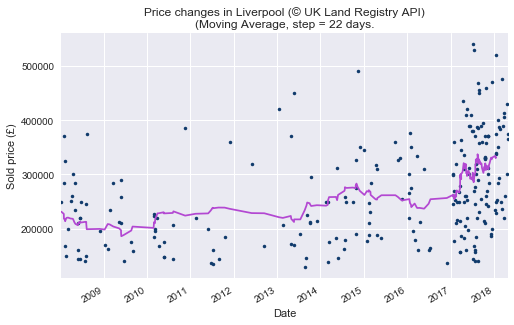

In [28]:
step = 22

sma = moving_average(df_cleaned['Sold price'].values, step)
print('Values of SMA are:\n{}.\n\nThe size of SMA is {} elements.'.format(sma,
                                                                       len(sma)))

df_cleaned = add_SMA_to_df(step, sma, df_cleaned)
plot_SMA(df_cleaned, step, area)

<h3>#2.10 Save the output to CSV file</h3>

In [29]:
df_cleaned.to_csv('{} (cleaned)_after.csv'.format(area))

<h3>#2.11 Removing first <code>step</code> rows for Regression Analysis</h3>

In [30]:
df_cleaned.head(step+5)

# Dropping first <step> rows for Regression analysis
df_cleaned.drop(df_cleaned.head(step).index, inplace = True)
print('\nThe dataframe after removing empty rows is:\n{}.'.format(df_cleaned.head(5)))


The dataframe after removing empty rows is:
          TOWN                                ADDRESS  Times sold  \
125  Liverpool  HIGH ROAD RAPHAEL HOUSE 250 FLAT 1901           3   
216  Liverpool                         SAXON ROAD 36            2   
210  Liverpool                     ROYSTON PARADE 29            2   
53   Liverpool                    COVENTRY ROAD 140A            2   
104  Liverpool                      HAMPTON ROAD 241            2   

                    Date  Days after 1st timestamp   Sold date  Sold price  \
125  2018-01-19 00:00:00                      3662   1-19-2018      340000   
216  2018-01-15 00:00:00                      3658   1-15-2018      375000   
210  2018-01-15 00:00:00                      3658   1-15-2018      520000   
53   2018-01-11 00:00:00                      3654   1-11-2018      234000   
104  2017-12-18 00:00:00                      3630  12-18-2017      200000   

        SMA  
125  331177  
216  330041  
210  330041  
53   334132  
1

c:\users\vytautas\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<h2>Regression Analysis</h2>

<h2>#3 Linear regression analysis</h2>

<h3>#3.1 Import modules </h3>

In [34]:
# Import module for linear regression
import statsmodels.api as sm

<h3>#3.2 Set <code>X</code> and <code>y</code> varianbles</h3>

In [35]:
X = df_cleaned['Days after 1st timestamp']
y = np.asarray(df_cleaned['SMA'].values)

In [36]:
print(df_cleaned.columns)
print(df_cleaned.iat[2, 7]), type(df_cleaned.iat[2, 7])

Index(['TOWN', 'ADDRESS', 'Times sold', 'Date', 'Days after 1st timestamp',
       'Sold date', 'Sold price', 'SMA'],
      dtype='object')
330040.909091


(None, numpy.float64)

<p>Let's add an intercept <code>beta_0</code> to our model.</p>

In [37]:
X = sm.add_constant(X)

In [38]:
print(X.head(3))

     const  Days after 1st timestamp
125    1.0                      3662
216    1.0                      3658
210    1.0                      3658


<h3>#3.3 Note the difference in argument order</h3>

In [39]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()

In [40]:
predictions = model.predict(X)

In [41]:
print(predictions.head(5))

125    302611.921675
216    302493.811690
210    302493.811690
53     302375.701706
104    301667.041800
dtype: float64


<h3>#3.4 Print the model statistics</h3>

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     704.3
Date:                Tue, 24 Jul 2018   Prob (F-statistic):           4.56e-70
Time:                        21:31:11   Log-Likelihood:                -2481.9
No. Observations:                 219   AIC:                             4968.
Df Residuals:                     217   BIC:                             4975.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.945e+05   3040.367     63.967      0.000    1.88e+05       2e+05
Days after 1st timestamp    29.5275      1.113     26.539      0.000      27.335      31.720
==============================================================================
Omnibus:                       15.519   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.450
Skew:                          -0.449   Prob(JB):                      0.00326
Kurtosis:                       2.330   Cond. No.                     6.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p>Extract parameters from model summary to build an equation for Linear Regression Analysis:</p>

In [43]:
param_1 = model.params[0]
param_2 = model.params[1]

In [44]:
print('The current model explain {:0.2f} % of dataset.'.format(model.rsquared * 100.0))
print('The equation for Linear Regression Analysis is:\ny = {:0.2f} + {:0.2f} × X.'.format(model.params[0],
                                                                   model.params[1]))

The current model explain 76.45 % of dataset.
The equation for Linear Regression Analysis is:
y = 194482.23 + 29.53 × X.


<h2>#4 Visualize trend for Linear Regression</h2>

In [45]:
def visualize_trend(df, param_1, param_2, area):
    
    #-------------------------------------------
    def add_trend_values(df, param_1, param_2):
        
        try:
            df.insert(len(df.columns), 'Trend values', None)
        except:
            print('The column already exist.\n')
            
        index_of_trend = df.columns.get_loc('Trend values')
        index_of_day = df.columns.get_loc('Days after 1st timestamp')
        
        for row in range(0, len(df), 1):
            df.iat[row, index_of_trend] = param_1 + df.iat[row, index_of_day] * param_2
            
        print('\n*** Trend values added! ***')
        return df
    #--------------------------------------------
    
    """
    args:
        df - dataframe after data pre-proceessing
        param_1 - constant
        param_2 - coefficient (multiplier)
    """
    
    df = add_trend_values(df, param_1, param_2)
    
    # Set the labels for plots
    title = 'Price changes in {} (© UK Land Registry API)\n(Moving Average, step = {} days.\n+ Trend line for Linear Regression Analysis'.format(area,
                                                                                                                                                 step)
    x_label = 'Sold date'
    y_label = 'Sold price (£)'
    
    
    
    timeline_1 = pd.Series(df['Sold price'].values, index = df['Date'])
    timeline_2 = pd.Series(df['SMA'].values, index = df['Date'])
    timeline_3 = pd.Series(df['Trend values'].values, index = df['Date'])
    
    plt.figure(figsize=(8,5))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    timeline_1.plot(style = 'k.', c = '#113b6c')
    timeline_2.plot(c = '#b348d2')
    timeline_3.plot(c = '#b50804')
    
    plt.show()      
    
    return None


*** Trend values added! ***


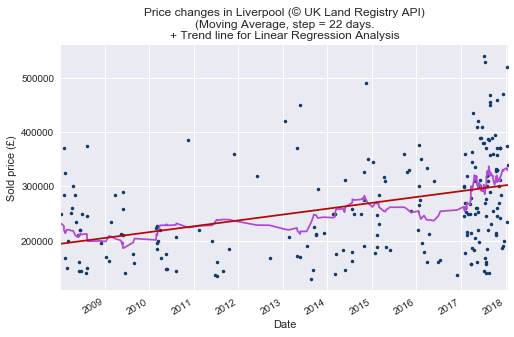

In [46]:
visualize_trend(df_cleaned, param_1, param_2, area)

<h2>#5 Determine additional metrics for the model</h2>

<h3>#5.1 Calculate Pearson correlation coefficient</h3>

In [47]:
# For getting Pearson correlation coeficient I use scipy library.
# It provide easy controlling and flexible functions to get values of stat. params.
from scipy import stats

In [48]:
pearson = stats.pearsonr(df_cleaned['SMA'].values, df_cleaned['Days after 1st timestamp'].values)
print('The Pearson correlation coefficient for the model is {:0.3f}.'.format(pearson[0]))

The Pearson correlation coefficient for the model is 0.874.
